<a href="https://colab.research.google.com/github/ShivamSinghal1/FacialEmotionRecognition/blob/master/RealTime_Facial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import tensorflow as tf
import keras
from keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def take_photo(filename='photo.jpg', quality=1):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [4]:
model_path2 = "/content/drive/My Drive/Dataset/ck_vgg16_v3.hdf5"
classifier = load_model(model_path2)
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
class_labels =   ['Angry','Contempt','Disgust','Fear','Happy','Sad' , 'Surprise'] 

In [5]:
def predict(frame):
  labels = []
  gray=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  faces = face_classifier.detectMultiScale(gray,1.3,5)

  for (x,y,w,h) in faces:
    cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h,x:x+w]
    roi_gray = cv2.resize(roi_gray,(48,48))

  if len(faces)!=0:
    roi = roi_gray.astype('float')/255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi,axis=0)
    # make a prediction on the ROI, then lookup the class

    preds = classifier.predict(roi)[0]
    label=class_labels[preds.argmax()]
    label_position = (x,y)
    cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),2)
  else:
    cv2.putText(frame,'No Face Found',(20,60),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),2)

  return frame

<IPython.core.display.Javascript object>

Saved to photo.jpg


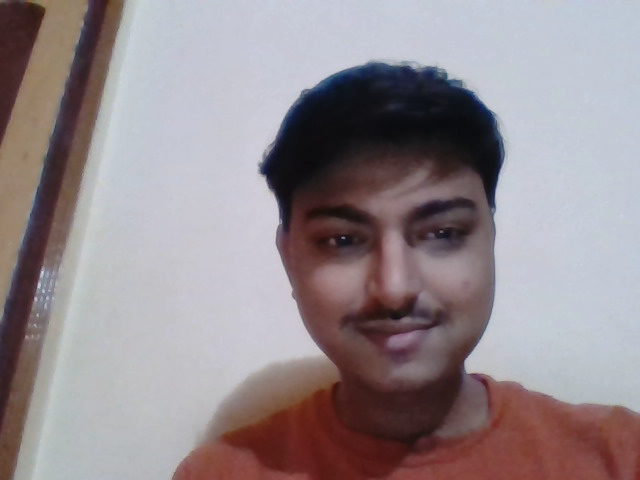

In [8]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

(-0.5, 639.5, 479.5, -0.5)

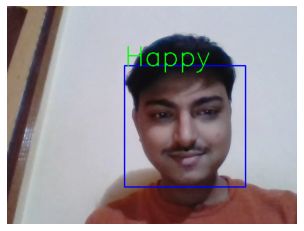

In [9]:
frame1 = cv2.imread('photo.jpg')
frame1 = predict(frame1)

fig = plt.figure()
plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
plt.axis('off')